Exploratory data analysis (EDA) is a crucial component of data science which allows you to understand the basics of what your data looks like and what kinds of questions might be answered. For this task, we are going to clean, sanitise and explore our data. Using the movies dataset, complete the steps outlined in this notebook by writing code in the cells.

In [1002]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import ast, json
from mlxtend.preprocessing import minmax_scaling, standardize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geoplot.crs as gcrs
import os


from matplotlib import style
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# visualization
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
from highlight_text import fig_text, ax_text
from matplotlib.patches import FancyArrowPatch


In [1003]:
#### Load the movies dataset 
movies_df = pd.read_csv('movies.csv')

# Load the geojson dataset
geoData = gpd.read_file('custom.geo.json')

# Load dataset with long and lat coordinates
long_late = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')

In [1004]:
geoData = geoData.loc[:, ['sovereignt', 'geometry']]

### Data Cleansing
#### Clean the data

Identify columns that are redundant or unnecessary. It is always easier to make your decisions based on data which is relevant and concise. Remove the following columns `['homepage', 'keywords', 'original_language', 'original_title', 'overview', 'production_companies', 'status', 'tagline']` from the data set as they will not be used in the analysis.

In [1005]:
movies_df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [1006]:
movies_df.drop(columns=['homepage', 'keywords', 'original_language', 'original_title'
                        , 'overview', 'production_companies', 'status', 'tagline'], inplace=True)

#### Remove any duplicate rows

In [1007]:
# Check if there are any duplicated values
duplicated_values = movies_df.duplicated().sum()
print(f"There are {duplicated_values} duplicated values in South Africa")

There are 0 duplicated values in South Africa


#### Remove rows with missing data 

Some movies in the database have zero budget or zero revenue which implies that their values have not been recorded or some information is missing. Discard such entries from the dataframe.

In [1008]:
# Check the size of the dataframe before dropping the values where the budget is zero, or where revenue is zero
movies_df.shape

(4803, 12)

In [1009]:
# Create condition to filter movies_df with
condition = (movies_df['budget'] == 0) | (movies_df['revenue'] == 0)

# Store the index values where the dataframe has been filtered with condition variable
conditional_index = movies_df.loc[condition].index

# Drop the stored index values
movies_df.drop(index=conditional_index, inplace=True)
print(f"Total rows dropped where budget, or revenue is zero: {len(conditional_index)} records")

Total rows dropped where budget, or revenue is zero: 1574 records


In [1010]:
# Check the size of the dataframe after dropping rows
movies_df.shape

(3229, 12)

#### Change data types
To manipulate the columns easily, it is important that we make use of the python objects. Change the release date column into `DateTime` format and extract the year from the date. This will help us in analysing yearly data.

In [1011]:
# confirm column datatype
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3229 non-null   int64  
 1   genres                3229 non-null   object 
 2   id                    3229 non-null   int64  
 3   popularity            3229 non-null   float64
 4   production_countries  3229 non-null   object 
 5   release_date          3229 non-null   object 
 6   revenue               3229 non-null   int64  
 7   runtime               3229 non-null   float64
 8   spoken_languages      3229 non-null   object 
 9   title                 3229 non-null   object 
 10  vote_average          3229 non-null   float64
 11  vote_count            3229 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 327.9+ KB


In [1012]:
# Change the release_date column to DateTime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], yearfirst=True, format= '%Y-%M-%d')

# Extract the release year from every release date, and store as a new column
movies_df['realease_year'] = movies_df['release_date'].dt.year

# Confirm colummn 'release_year' has been added and that the 'release_date' has been converted into a datetime
# object
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                3229 non-null   int64         
 1   genres                3229 non-null   object        
 2   id                    3229 non-null   int64         
 3   popularity            3229 non-null   float64       
 4   production_countries  3229 non-null   object        
 5   release_date          3229 non-null   datetime64[ns]
 6   revenue               3229 non-null   int64         
 7   runtime               3229 non-null   float64       
 8   spoken_languages      3229 non-null   object        
 9   title                 3229 non-null   object        
 10  vote_average          3229 non-null   float64       
 11  vote_count            3229 non-null   int64         
 12  realease_year         3229 non-null   int32         
dtypes: datetime64[ns](1), f

Change budget and revenue columns to a integer data type using numpy’s `int64` method.

In [1013]:
# Use as type and pass a dictionary to change the dtype of the columns passed as keys, 
# into the datatype values passed as values
movies_df = movies_df.astype(
    {'budget': 'int64',
     'revenue': 'int64'}
)

In [1014]:
# Confirm changes to budget and revenue columns
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                3229 non-null   int64         
 1   genres                3229 non-null   object        
 2   id                    3229 non-null   int64         
 3   popularity            3229 non-null   float64       
 4   production_countries  3229 non-null   object        
 5   release_date          3229 non-null   datetime64[ns]
 6   revenue               3229 non-null   int64         
 7   runtime               3229 non-null   float64       
 8   spoken_languages      3229 non-null   object        
 9   title                 3229 non-null   object        
 10  vote_average          3229 non-null   float64       
 11  vote_count            3229 non-null   int64         
 12  realease_year         3229 non-null   int32         
dtypes: datetime64[ns](1), f

On checking the dataset, we see that `genres`, `production_countries`, `spoken_languages` are in the JSON format which will make it difficult to manipulate the dataframe. The `parse_col_json function` flattens these columns into a format that can be easily interpreted.

In [1015]:
movies_df.head()

,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,150.437577,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-01-10 00:12:00,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800,2009
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,139.082615,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-01-19 00:05:00,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500,2007
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,107.376788,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-01-26 00:10:00,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466,2015
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,112.312950,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-01-16 00:07:00,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106,2012
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,43.926995,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-01-07 00:03:00,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124,2012


In [1016]:
# Convert from JSON format to a list of strings
def parse_col_json(column, key):
    """
    Args:
        column: string
            name of the column to be processed.
        key: string
            name of the dictionary key which needs to be extracted
    """
    for index,i in zip(movies_df.index, movies_df[column].apply(json.loads)):
        list1=[]
        for j in range(len(i)):
            list1.append((i[j][key]))# the key 'name' contains the name of the genre
        movies_df.loc[index, column] = ', '.join(list1) #Flatten the list into a string before appending
    
# Flatten data in columns
parse_col_json('genres', 'name')
parse_col_json('production_countries', 'name')
parse_col_json('spoken_languages', 'name')


In [1017]:
# Inspect flattened data
movies_df.sample(1)

,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year
1030,47000000,"Drama, Horror, Thriller, Romance",9095,6.067212,United States of America,1996-01-23 00:02:00,12379402,104.0,English,Mary Reilly,5.7,74,1996


In [1018]:
movies_df['genres'].value_counts()

genres
Drama                                           204
Comedy                                          197
Drama, Romance                                   96
Comedy, Romance                                  87
Comedy, Drama                                    70
                                               ... 
Mystery, Drama, Thriller                          1
Documentary, Comedy, Drama                        1
Drama, Action, Comedy                             1
Horror, Comedy, Crime                             1
Animation, Family, Action, Adventure, Comedy      1
Name: count, Length: 933, dtype: int64

### Finding Certain Genres
Locate all movies in the "Action" genre. 

In [1019]:
# Create a dataframe with all the movies in the "Action" genre

actions_index = []
# Iterate over the index and the values of the genres column
for index, value in movies_df['genres'].items():
    # apply split function in order to turn string to list
    value = value.split()
    # Use membership operation to check if 'Action' is in the split value variable
    if 'Action' in value:
        # Append index to actions_index
        actions_index.append(index)

# Filter the daterframe by the index values of actions_index
action_movies = movies_df.loc[actions_index, :]

In [1020]:
action_movies.head()

,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year
1,300000000,"Adventure, Fantasy, Action",285,139.082615,United States of America,2007-01-19 00:05:00,961000000,169.0,English,Pirates of the Caribbean: At World's End,6.9,4500,2007
12,200000000,"Adventure, Fantasy, Action",58,145.847379,"Jamaica, United States of America, Bahamas, Do...",2006-01-20 00:06:00,1065659812,151.0,"English, Türkçe, ελληνικά, 普通话",Pirates of the Caribbean: Dead Man's Chest,7.0,5246,2006
24,207000000,"Adventure, Drama, Action",254,61.226010,"New Zealand, United States of America, Germany",2005-01-14 00:12:00,550000000,187.0,English,King Kong,6.6,2337,2005
44,190000000,Action,168259,102.322217,"Japan, United States of America",2015-01-01 00:04:00,1506249360,137.0,English,Furious 7,7.3,4176,2015
53,185000000,"Adventure, Action",217,75.674458,United States of America,2008-01-21 00:05:00,786636033,122.0,"English, Deutsch, Pусский",Indiana Jones and the Kingdom of the Crystal S...,5.7,2495,2008


### Now onto the exploration

#### Identify relationships between variables (features)

The main goal here is to identify and create relationships that can help you formulate ideas. We have defined questions to help you identify some relationships to explore.

#### Which are the 5 most expensive movies? 

How do the most expensive and cheapest movies compare? Exploring the most expensive movies highlights if some movies are worth the money spent on them based on their performance and revenue generated.

In [1021]:
# Store the numeric features of the dataset into one dataframe
numeric_features_df = movies_df.select_dtypes(include='number')
numeric_features_df.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,realease_year
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,2009
1,300000000,285,139.082615,961000000,169.0,6.9,4500,2007
2,245000000,206647,107.376788,880674609,148.0,6.3,4466,2015
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106,2012
4,260000000,49529,43.926995,284139100,132.0,6.1,2124,2012


In [1022]:
# Store the object features of the dataset into one dataframe
object_features_df = movies_df.select_dtypes(exclude='number')
object_features_df.head()

,genres,production_countries,release_date,spoken_languages,title
0,"Action, Adventure, Fantasy, Science Fiction","United States of America, United Kingdom",2009-01-10 00:12:00,"English, Español",Avatar
1,"Adventure, Fantasy, Action",United States of America,2007-01-19 00:05:00,English,Pirates of the Caribbean: At World's End
2,"Action, Adventure, Crime","United Kingdom, United States of America",2015-01-26 00:10:00,"Français, English, Español, Italiano, Deutsch",Spectre
3,"Action, Crime, Drama, Thriller",United States of America,2012-01-16 00:07:00,English,The Dark Knight Rises
4,"Action, Adventure, Science Fiction",United States of America,2012-01-07 00:03:00,English,John Carter


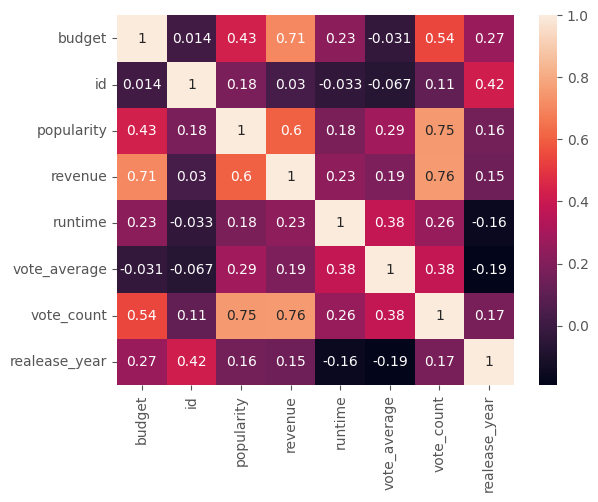

In [1023]:
sns.heatmap(numeric_features_df.corr(), annot=True)
plt.show()

In [1036]:
# Find the most correlated features to budget (pearson correlation coeeficient of 0.5 or greater, or less than 0.5) and store the feature names
most_corr = numeric_features_df.corr()['budget'][(numeric_features_df.corr()['budget'] > 0.5) | (numeric_features_df.corr()['budget'] < -0.5)].index.tolist()
most_corr

['budget', 'revenue', 'vote_count']

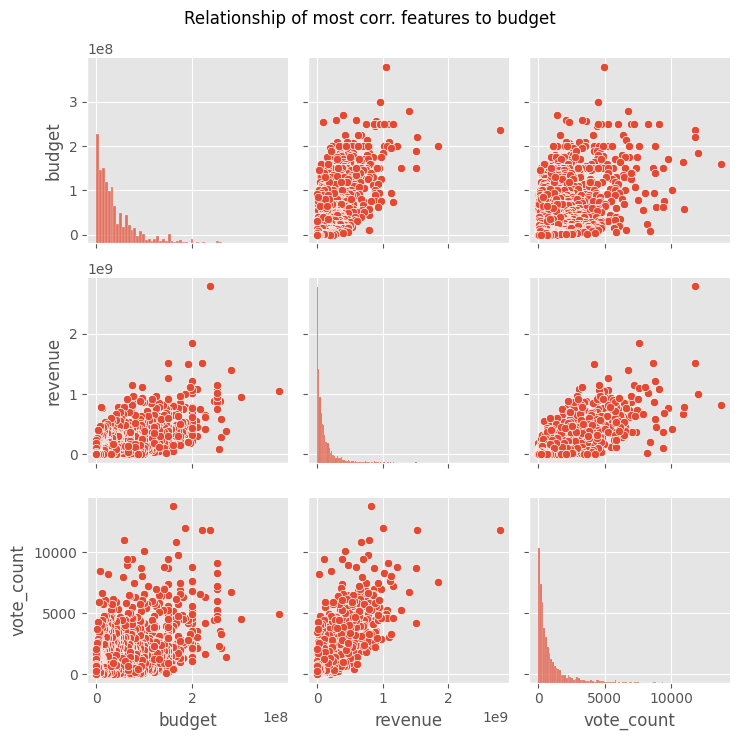

In [1035]:
# Return a pairplot of the most correlated features
fig = sns.pairplot(movies_df.loc[:, most_corr])
fig.figure.suptitle('Relationship of most corr. features to budget')
plt.tight_layout()
plt.show()

In [ ]:
# Store the top 5 most expensive movies based budget
top_5_budget = movies_df.sort_values(by=['budget'], ascending=False).reset_index().head()
# Return the top 5 movies and their budget and revenue
for i in range(top_5_budget.shape[0]):
    print(f"{i+1}.\nMovie: {top_5_budget.at[i,'title']}\nBudget: ${top_5_budget.at[i,'budget']}")
    print(f"Revenue: ${top_5_budget.at[i,'revenue']}")
    print(f"Profit: ${top_5_budget.at[i,'revenue'] - top_5_budget.at[i,'budget']}\n")

1.
Movie: Pirates of the Caribbean: On Stranger Tides
Budget: $380000000
Revenue: $1045713802
Profit: $665713802

2.
Movie: Pirates of the Caribbean: At World's End
Budget: $300000000
Revenue: $961000000
Profit: $661000000

3.
Movie: Avengers: Age of Ultron
Budget: $280000000
Revenue: $1405403694
Profit: $1125403694

4.
Movie: Superman Returns
Budget: $270000000
Revenue: $391081192
Profit: $121081192

5.
Movie: John Carter
Budget: $260000000
Revenue: $284139100
Profit: $24139100



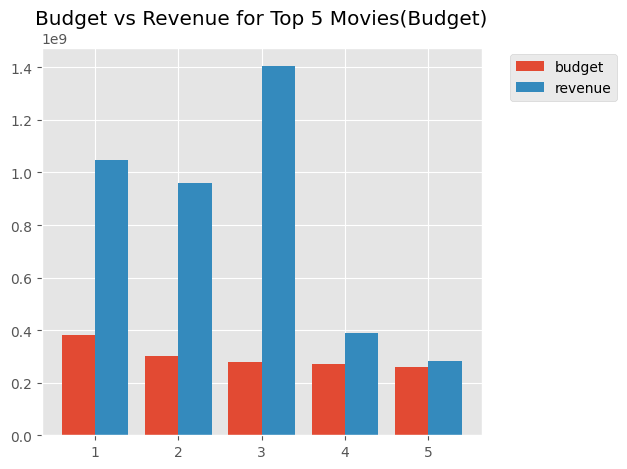

In [ ]:
style.use('ggplot')
fig, ax = plt.subplots()
x_pos = np.arange(1, len(top_5_budget['budget']) + 1)
barwidth = 0.4

plt.bar(x_pos, top_5_budget['budget'], width=barwidth, label='budget')
plt.bar(x_pos+barwidth, top_5_budget['revenue'], width=barwidth, label='revenue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Budget vs Revenue for Top 5 Movies(Budget)')
plt.xticks(x_pos + 0.2, x_pos)
plt.tight_layout()
plt.show()

#### What are the top 5 most profitable movies? 

Compare the min and max profits. The comparison helps us identify the different approaches which failed and succeeded. Subtracting the budget from the revenue generated, will return the profit earned.

In [ ]:
# Create a new column, 'returns' from the difference between the revenue and budget values of each record
movies_df['returns'] = movies_df['revenue'] - movies_df['budget']

In [ ]:
# Store the top 5 movies based on profit returns
top_5_returns = movies_df.sort_values(by=['returns'], ascending=False).reset_index().head()

# Return the top 5 movies and their budget and returns
for i in range(top_5_returns.shape[0]):
    print(f"{i+1}.\nMovie: {top_5_returns.at[i,'title']}\nBudget: {top_5_returns.at[i,'budget']}")
    print(f"Profit: ${top_5_returns.at[i,'returns']}\n")

1.
Movie: Avatar
Budget: 237000000
Profit: $2550965087

2.
Movie: Titanic
Budget: 200000000
Profit: $1645034188

3.
Movie: Jurassic World
Budget: 150000000
Profit: $1363528810

4.
Movie: Furious 7
Budget: 190000000
Profit: $1316249360

5.
Movie: The Avengers
Budget: 220000000
Profit: $1299557910



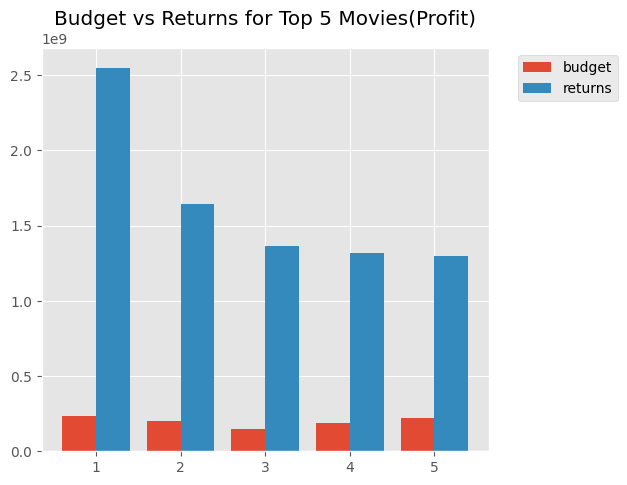

In [ ]:
style.use('ggplot')
fig, ax = plt.subplots()
x_pos = np.arange(1, len(top_5_returns['returns']) + 1)
barwidth = 0.4

plt.bar(x_pos, top_5_returns['budget'], width=barwidth, label='budget')
plt.bar(x_pos+barwidth, top_5_returns['returns'], width=barwidth, label='returns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Budget vs Returns for Top 5 Movies(Profit)')
plt.xticks(x_pos + 0.2, x_pos)
plt.tight_layout()
plt.show()

#### Find the most popular movies. 
Sort the dataframe based on the popularity column.

In [ ]:
movie_popularity = movies_df.sort_values(by='popularity', ascending=False)
movie_popularity.head()

,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year,returns
546,74000000,"Family, Animation, Adventure, Comedy",211672,875.581305,United States of America,2015-01-17 00:06:00,1156730962,91.0,English,Minions,6.4,4571,2015,1082730962
95,165000000,"Adventure, Drama, Science Fiction",157336,724.247784,"Canada, United States of America, United Kingdom",2014-01-05 00:11:00,675120017,169.0,English,Interstellar,8.1,10867,2014,510120017
788,58000000,"Action, Adventure, Comedy",293660,514.569956,United States of America,2016-01-09 00:02:00,783112979,108.0,English,Deadpool,7.4,10995,2016,725112979
94,170000000,"Action, Science Fiction, Adventure",118340,481.098624,"United Kingdom, United States of America",2014-01-30 00:07:00,773328629,121.0,English,Guardians of the Galaxy,7.9,9742,2014,603328629
127,150000000,"Action, Adventure, Science Fiction, Thriller",76341,434.278564,"Australia, United States of America",2015-01-13 00:05:00,378858340,120.0,English,Mad Max: Fury Road,7.2,9427,2015,228858340


#### Find Movies which are rated above 7

In [ ]:
# Store a slice of the dataframe with the average rating being above 7.Start by slicing the dataframe by using
# condition, sort the values by the column 'vote_average' in descending order.
vote_gt_7 = movies_df[movies_df['vote_average'] > 7].sort_values(by='vote_average', ascending=False).reset_index()
vote_gt_7.head()

,index,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year,returns
0,2970,10500000,"Drama, Comedy",88641,0.037073,United States of America,1994-01-02 00:09:00,123509,99.0,English,There Goes My Baby,8.5,2,1994,-10376491
1,1881,25000000,"Drama, Crime",278,136.747729,United States of America,1994-01-23 00:09:00,28341469,142.0,English,The Shawshank Redemption,8.5,8205,1994,3341469
2,3337,6000000,"Drama, Crime",238,143.659698,United States of America,1972-01-14 00:03:00,245066411,175.0,"English, Italiano, Latin",The Godfather,8.4,5893,1972,239066411
3,662,63000000,Drama,550,146.757391,"Germany, United States of America",1999-01-15 00:10:00,100853753,139.0,English,Fight Club,8.3,9413,1999,37853753
4,2731,13000000,"Drama, Crime",240,105.792936,United States of America,1974-01-20 00:12:00,47542841,200.0,"English, Italiano, Latin, Español",The Godfather: Part II,8.3,3338,1974,34542841


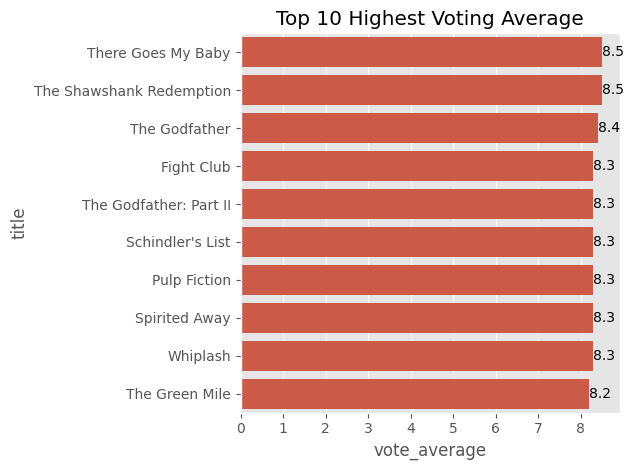

In [1041]:
fig, ax = plt.subplots()
sns.barplot(vote_gt_7[:10], 
            y='title',
            x='vote_average')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Highest Voting Average')
plt.tight_layout()
plt.show()


In [ ]:
print(f"There are {vote_gt_7.shape[0]} movies with a voter average greater than 7.\n")
print(f"'{vote_gt_7.at[0, 'title']}' has the most votes with {vote_gt_7.at[0, 'vote_average']} votes.")
print(f"'{vote_gt_7.at[1, 'title']}' has the second most votes with {vote_gt_7.at[1, 'vote_average']} votes.")
print(f"'{vote_gt_7.at[2, 'title']}' has the third most votes with {vote_gt_7.at[2, 'vote_average']} votes.")

There are 637 movies with a voter average greater than 7.

'There Goes My Baby' has the most votes with 8.5 votes.
'The Shawshank Redemption' has the second most votes with 8.5 votes.
'The Godfather' has the third most votes with 8.4 votes.


#### Most successful genres 
Create a bar plot explaining the frequency of movies in each genre.

Plan of action
___

1. Each movie potentially has more than one value in its genre column. Therefore, the `string object` needs `to` be converted into a `list of genres`. 

3. `Convert` the `array nested list` into a `flattened list`

4. Create a `genre dataframe`

5. Apply the value_counts() method on the genre dataframe to `return a frequency table` series

6. `Plot` the graph

NOTE: 

* Splitting of the genre column is crucial so that we are able to treat each genre value in one record as seperate values. 

In [ ]:
# Split each string across the genre column to create a list of all the genres a movie is categorised in
genre_nested_array = movies_df['genres'].apply(lambda x: x.split(',')).values

# Use ternary operator for to filter by the titles with more than one genre, and then uselist comprehension to
# flatten the list
genre_list = [element.strip() for sublist in genre_nested_array.tolist() for element in sublist if len(sublist) >  1]

# Create a range index that will act as a 
range_index = pd.RangeIndex.from_range(range(0, len(genre_list)))

# Create a dataframe for genres
genre_df = pd.DataFrame(data=genre_list, columns=['genres'], index=range_index)

# Create frequency table of all the genres
genre_freq = genre_df.groupby('genres')['genres'].count().sort_values(ascending=False)
genre_freq

genres
Drama              1237
Thriller            925
Comedy              913
Action              901
Adventure           652
Romance             571
Crime               521
Science Fiction     420
Family              365
Fantasy             337
Horror              296
Mystery             265
Animation           187
History             144
War                 118
Music               109
Western              42
Documentary          16
Foreign               5
Name: genres, dtype: int64

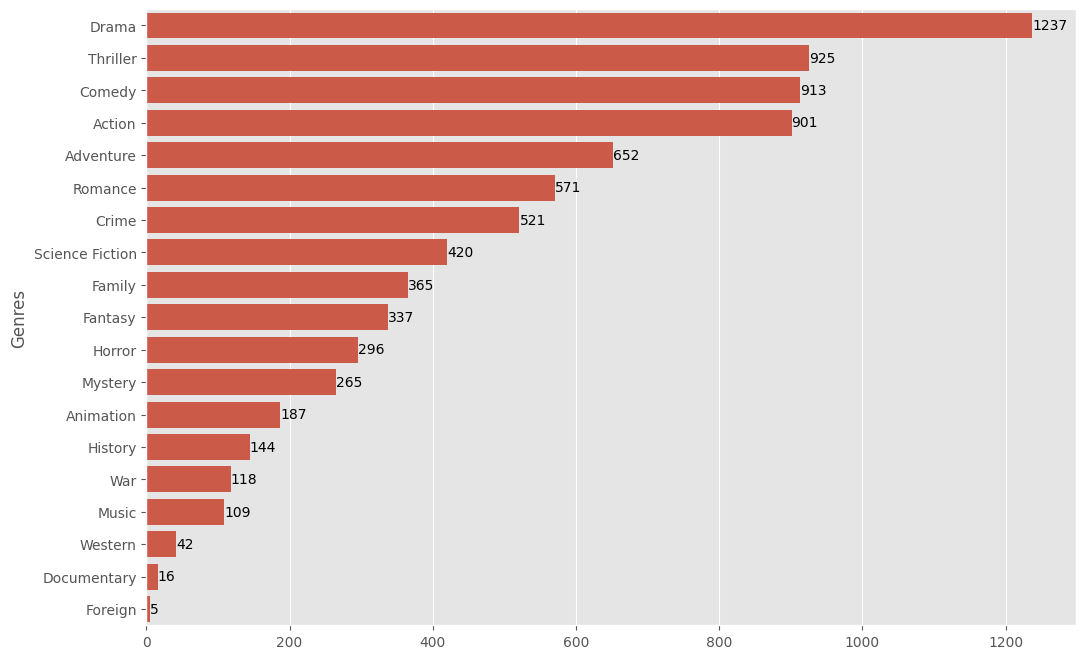

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=genre_freq, orient='h', ax=ax)
ax.bar_label(ax.containers[0])
plt.xlabel('')
plt.ylabel('Genres')
plt.show()

In [ ]:
# Generate three different interesting visualisations with a data story.

##### 1. Revenue by release period and Total movies released per period. 

In [ ]:
# Create the bins and the labels to add to the dataframe using the 'realease_year' as a point of reference
bins = [0, 1999, 2005, 2010, 2015, 2016 ]
labels = ['pre-2000', '2000 - 2005', '2006 - 2010', '2011 - 2015', 'post-2016']

movies_df['release_period'] = pd.cut(movies_df['realease_year'], bins=bins, labels=labels)

In [ ]:
# Returns by release_period
period_returns = movies_df.groupby('release_period', observed=False)['returns'].mean()
period_returns

period_count = movies_df.groupby('release_period', observed=False)['release_period'].count()
period_count

release_period
pre-2000       947
2000 - 2005    748
2006 - 2010    749
2011 - 2015    713
post-2016       72
Name: release_period, dtype: int64

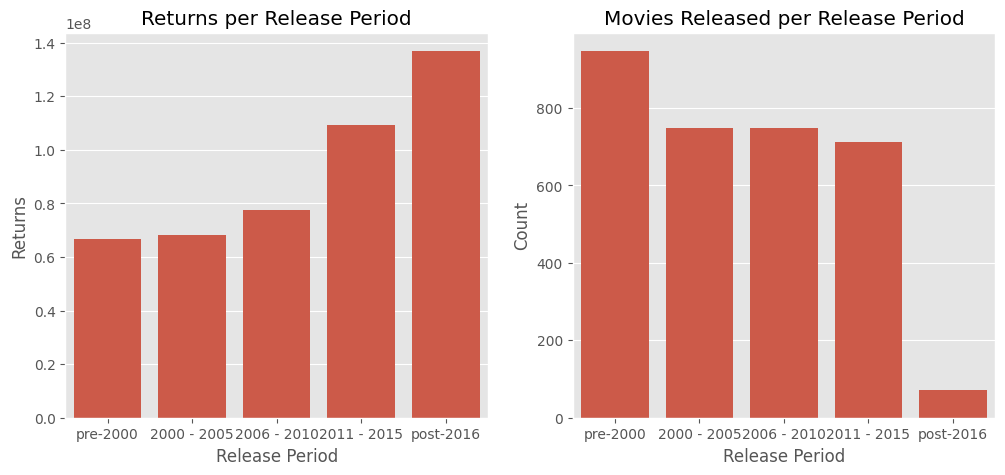

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(period_returns, ax=ax[0])
ax[0].set_xlabel('Release Period')
ax[1].set_xlabel('Release Period')
ax[0].set_ylabel('Returns')
ax[1].set_ylabel('Count')
ax[0].set_title('Returns per Release Period')
ax[1].set_title('Movies Released per Release Period')
sns.barplot(period_count, ax=ax[1])
plt.show()

In [ ]:
def total_movies_per_genre_per_period(release_period: str) -> None:
    """
    A function that prints the top 5 most popular genres for each release_period

    Args:
        release_period: string
        Value name in the release_period column
    """
    total_genres_series = movies_df[movies_df['release_period'] == release_period][['genres']]
    genre_list = [genre for sublist in total_genres_series['genres'].str.split(', ') for genre in sublist]

    genres = pd.DataFrame(genre_list, index=range(len(genre_list)))
    print(
        f"Top 5 Most Popular Genres For {release_period}:"
        f"{genres[0].value_counts(normalize=True).nlargest(5) * 100}\n"
    )

In [ ]:
for period in movies_df['release_period'].unique():
    total_movies_per_genre_per_period(period)

Top 5 Most Popular Genres For 2006 - 2010:0
Drama        17.667668
Comedy       13.963964
Thriller     10.360360
Action        9.359359
Adventure     7.207207
Name: proportion, dtype: float64

Top 5 Most Popular Genres For 2011 - 2015:0
Drama        17.439911
Comedy       12.800447
Action       11.458916
Thriller     11.458916
Adventure     7.769704
Name: proportion, dtype: float64

Top 5 Most Popular Genres For post-2016:0
Action       16.483516
Adventure    12.087912
Drama        12.087912
Comedy       11.538462
Thriller     10.439560
Name: proportion, dtype: float64

Top 5 Most Popular Genres For 2000 - 2005:0
Drama       16.376307
Comedy      14.335490
Thriller    11.348930
Action      10.652066
Romance      7.864609
Name: proportion, dtype: float64

Top 5 Most Popular Genres For pre-2000:0
Drama        16.460108
Comedy       11.347792
Action       10.921766
Thriller     10.689388
Adventure     8.055771
Name: proportion, dtype: float64



`NOTE`:

* From the plot, we can surmise that the total returns from movies has steadily increased over each period of time. The interesting thing is that even though the total number of movies released during the 'post-2016' period shows to be the lowest with regards to releases, it is during this period where we find the most profitable movies coming out. 

* Interestingly as well, from the above output, we can also see that from '2006 - 2010' period, there has been a steady increase in the ratio of action and adventure movies coming to the fore. According to Chatgbt, Science Fiction, Fantasy, Superhero, Action/Adventure, Animated Films and Horror, are the genres which leverage CGI (Computer-Generated Imagery) (Which movie genres uses the most cgi on average?, 2024). Based on the top 5 most profitable movies produced in cell 37 and 38, we can see that there is some truth in this. 

* Adventure, action, sci-fi and fantasy movies take the longest to reach theatre from the first announcement, averaging at least 1000 days. These total days include first announcement, pre-production, shooting, and post-production. These categories also experience the longest first announcements, this could be because of many reasons, but one of the major reasons is to signal their intent to rival studios.  This may help them secure a prime release slot in the calendar or ensure there is no competition for their movie’s topic or theme. (Stephen Follows, 2018)

##### 2. Total Movies produced per year

In [ ]:
movie_production = movies_df.groupby('realease_year')['id'].count()
movie_production

realease_year
1916      1
1925      1
1927      1
1929      1
1930      1
       ... 
2012    137
2013    152
2014    135
2015    121
2016     72
Name: id, Length: 89, dtype: int64

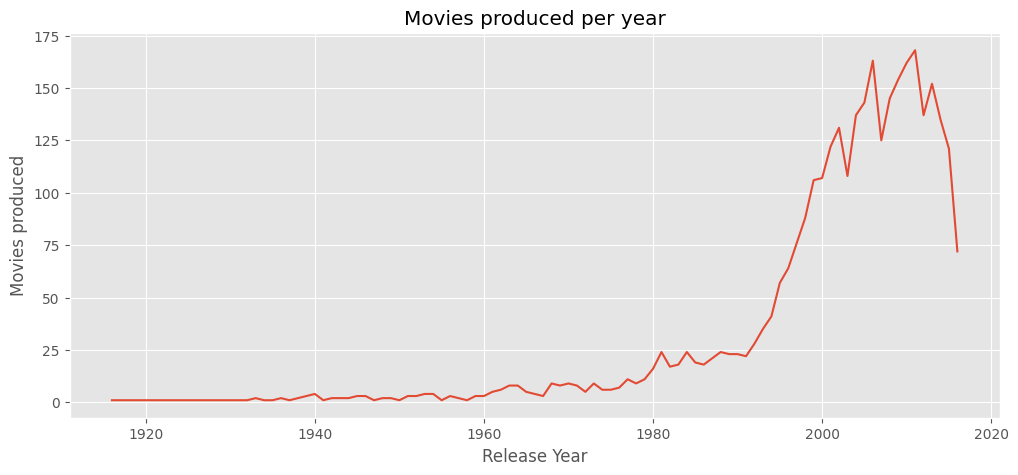

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(movie_production)
plt.title('Movies produced per year')
plt.ylabel('Movies produced')
plt.xlabel('Release Year')
plt.show()

##### 3. Compare the total average return by movies with different number of genres included

In [ ]:
# for each value in the genres column, store the genres as a list
split_genre = movies_df['genres'].apply(lambda x: x.split(','))

# Use list comprehension to get the total number of genres in each movie record
genre_totals = [len(value) for value in split_genre]

# Insert the column total_no_of_genres to the left of id column
movies_df.insert(loc=movies_df.columns.get_loc('id')
                 , column='total_no_of_genres'
                 , value=genre_totals)

movies_df.head()

,budget,genres,total_no_of_genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year,returns,release_period
0,237000000,"Action, Adventure, Fantasy, Science Fiction",4,19995,150.437577,"United States of America, United Kingdom",2009-01-10 00:12:00,2787965087,162.0,"English, Español",Avatar,7.2,11800,2009,2550965087,2006 - 2010
1,300000000,"Adventure, Fantasy, Action",3,285,139.082615,United States of America,2007-01-19 00:05:00,961000000,169.0,English,Pirates of the Caribbean: At World's End,6.9,4500,2007,661000000,2006 - 2010
2,245000000,"Action, Adventure, Crime",3,206647,107.376788,"United Kingdom, United States of America",2015-01-26 00:10:00,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Spectre,6.3,4466,2015,635674609,2011 - 2015
3,250000000,"Action, Crime, Drama, Thriller",4,49026,112.312950,United States of America,2012-01-16 00:07:00,1084939099,165.0,English,The Dark Knight Rises,7.6,9106,2012,834939099,2011 - 2015
4,260000000,"Action, Adventure, Science Fiction",3,49529,43.926995,United States of America,2012-01-07 00:03:00,284139100,132.0,English,John Carter,6.1,2124,2012,24139100,2011 - 2015


In [ ]:
no_of_genres_revenue = movies_df.groupby('total_no_of_genres')[['revenue']].mean().reset_index()
no_of_genres_revenue

,total_no_of_genres,revenue
0,1,7.111810e+07
1,2,9.234433e+07
2,3,1.466910e+08
3,4,1.606778e+08
4,5,1.642810e+08
5,6,1.303996e+08
6,7,7.103863e+07


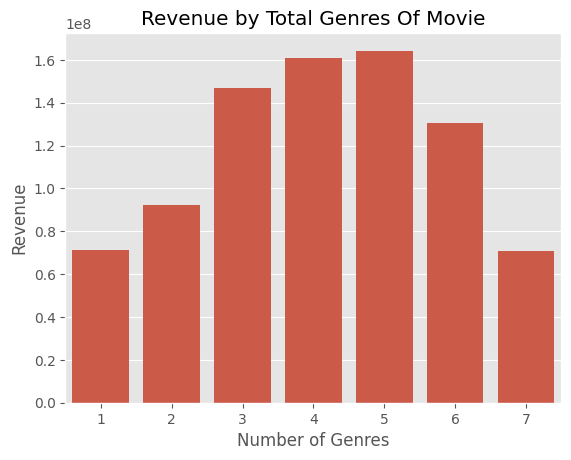

In [ ]:
sns.barplot(no_of_genres_revenue, x='total_no_of_genres', y='revenue')
plt.title('Revenue by Total Genres Of Movie')
plt.ylabel('Revenue')
plt.xlabel('Number of Genres')
plt.show()

`NOTE`:

From the barplot above, there seems to be a threshold where the total number of genres suggests that movies that include multiple genres, tend to get to a larger audience, and that it could result in greater revenue. However, this relationship could also be further researched to find if there is a combination of movies that return a greater revenue that others.

##### 4. What is the relationship between budget and returns?

`NOTE`:

* The assumption is made that the first genre in the genres multiple values, is the most accurate description of the movie. This assumption will be made to categorise the movies

In [ ]:
# Use ternary operator and list comprehension to achieve the first genre in genres value for each value in column
# 'genres'
main_genre = [genre[0] for genre in movies_df['genres'].str.split(', ')]
# Insert the column on the right of genres column
movies_df.insert(loc=movies_df.columns.get_loc('total_no_of_genres')
                 , column='main_genre'
                 , value=main_genre)

movies_df.head(2)

,budget,genres,main_genre,total_no_of_genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year,returns,release_period
0,237000000,"Action, Adventure, Fantasy, Science Fiction",Action,4,19995,150.437577,"United States of America, United Kingdom",2009-01-10 00:12:00,2787965087,162.0,"English, Español",Avatar,7.2,11800,2009,2550965087,2006 - 2010
1,300000000,"Adventure, Fantasy, Action",Adventure,3,285,139.082615,United States of America,2007-01-19 00:05:00,961000000,169.0,English,Pirates of the Caribbean: At World's End,6.9,4500,2007,661000000,2006 - 2010


`NOTES`

* There seems to be a movie(s) with no recognised genre. Find the movie and drop from the dataframe

In [ ]:
# Find the movie with no main_genre
movies_df[movies_df['main_genre'] == '']

,budget,genres,main_genre,total_no_of_genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,realease_year,returns,release_period
4105,2000000,,,1,48382,0.031947,,2003-01-12 00:09:00,1672730,120.0,,"The Book of Mormon Movie, Volume 1: The Journey",5.0,2,2003,-327270,2000 - 2005


In [ ]:
# Dynamically store the index values 
drop_index = movies_df[movies_df['main_genre'] == ''].index

In [ ]:
# Drop the movie with no genre
movies_df.drop(index=drop_index, inplace=True)

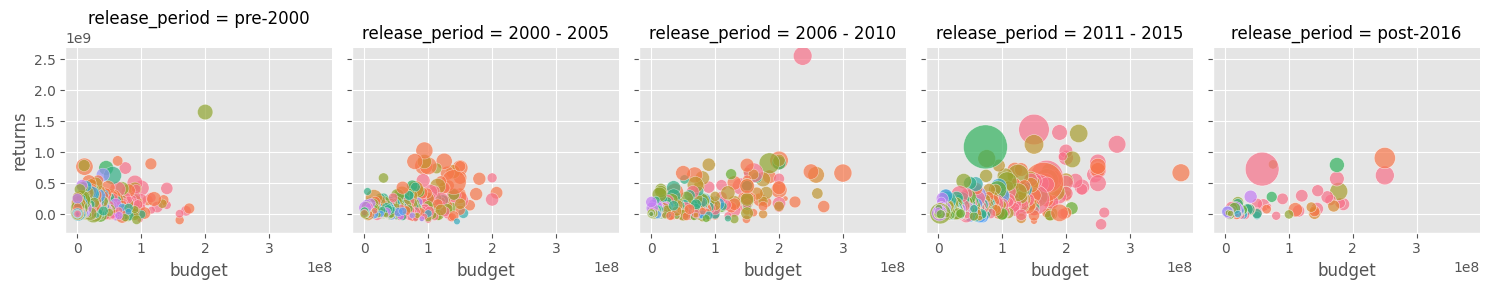

In [ ]:
fg = sns.FacetGrid(movies_df, col='release_period', margin_titles=True)
fg.map(sns.scatterplot
       , 'budget'
       , 'returns'
       , hue=movies_df['main_genre']
       , size=movies_df['popularity']
       , sizes=(10, 1000)
       , alpha=0.7)
plt.tight_layout()
plt.show()
fg.add_legend(bbox_to_anchor=(1.05,1), loc='upper left')

In [ ]:
# Store a copy of the dataframe in a variable
df2 = movies_df.copy()

# Store the index of the the  movies where the production_countries is an empty string
dropped_index = df2[df2['production_countries'] == ''].index

# Drop the index on the copied dataframe
df2.drop(index=dropped_index, inplace=True)

In [ ]:
locations = df2['production_countries'].str.split(', ')
counter = 0
for loc in locations.values:
    if counter == 0:
        new = loc
        counter += 1
    else:    
        new.extend(loc)

# Store all the shooting sights
all_locations = new

# Create a dataframe of the all the locations and the number of times the location was used for the shoot
location_count_df = (
    pd.DataFrame(all_locations).groupby(0)[[0]]
                               .count()
                               .rename({0:'count'}, axis=1)
                               .sort_values(by='count', ascending=False)
                               .reset_index()
                               .rename({0: 'country'}, axis=1)
)
location_count_df

,country,count
0,United States of America,2908
1,United Kingdom,436
2,Germany,233
3,France,196
4,Canada,162
...,...,...
56,Singapore,1
57,Slovenia,1
58,Serbia,1
59,Serbia and Montenegro,1


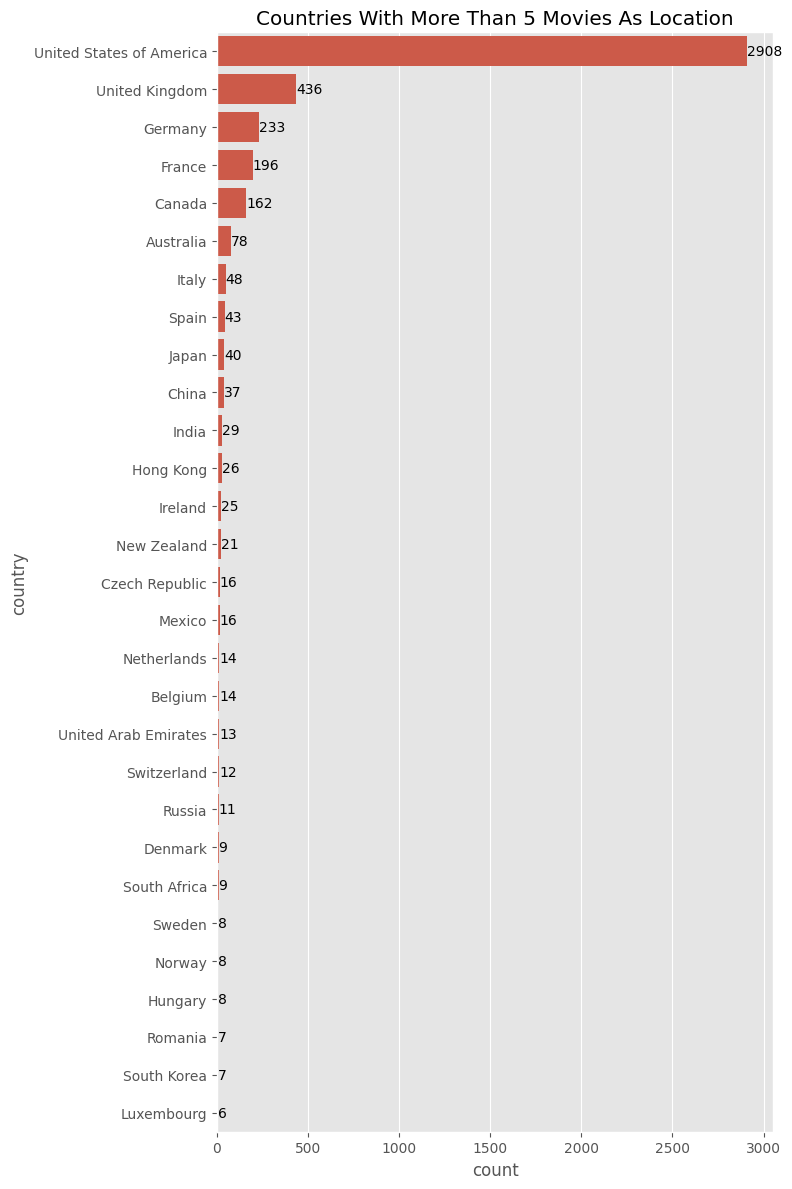

In [ ]:
_, ax = plt.subplots(figsize=(8, 12))
sns.barplot(location_count_df[location_count_df['count'] > 5],
            y='country',
            x='count',
            errorbar=None,
            ax=ax)
ax.bar_label(ax.containers[0])
plt.title('Countries With More Than 5 Movies As Location')
plt.tight_layout()
plt.show()

`NOTE`:

* From the barplot we can see that from the dataset, the most popular country for mobie features, is the United States. In an article by Kyle Deguzman (2024) that in Hollywood, the term 'big studio' refers to a film production company that not only produces films but also distributes them. These movie studios have large, dedicated facilities, significant resources, and a substantial workforce. They have the capacity to handle all aspects of film production, from scriptwriting and filming to post-production and distribution. 

* With the description of a big studio in mind, based on another article written by Ria Puneyani (2023), based on the total revenue generated from their movies at the time, the 10 biggest production companies in the world are, 1. _`Universal Pictures`_ with a total revenue of $11.62 billion, 2. _`Warner Bros`_ with a total revenue of $44.3 billion, 3. _`The Sony Pictures Motion Picture Group`_ with a total revenue of $7.16 billion, 4. _`Walt Disney Pictures`_ with $82.7 billion total revenue, 5. _`Paramount`_ with a total revenue of $30.15 bllion, 6._`Lionsgate`_ with a total revenue of $35.97 billion, 7. _`20th Century Fox`_ with a total of $47 million, 8. _`Weinstein Company`_ comes in 8th with a total revenue of $33.9 million, followed by _`Metro-Goldwyn-Mayer Studios`_ at 9th with a total revenue of $13.1 billion, and finally, at 10. _`DreamWorks Studios`_ with a total revenue of $915.9 million. 

* Therefore, we can deduce that having the top ten movie production companies being based, in the United States of America, it makes sense why the country is the most popular site for movie production.

In [ ]:
proj = ccrs.Mercator()
# Flatten the countries into a 2d projection
geoData = geoData.to_crs(proj.proj4_init)
# Create new column, 'point', which will have the centroids of each geometric shape of each country
geoData['point'] = geoData['geometry'].centroid
geoData.head()

,sovereignt,geometry,point
0,Costa Rica,"POLYGON ((-9190935.04 1063963.789, -9191565.56...",POINT (-9372344.096 1109035.81)
1,Nicaragua,"POLYGON ((-9257052.73 1677353.451, -9260150.97...",POINT (-9465472.099 1433450.236)
2,France,"POLYGON ((-7014372.655 2032374.047, -7026825.4...",POINT (-7019776.832 2034695.151)
3,Netherlands,"POLYGON ((-7026825.435 2032374.047, -7014372.6...",POINT (-7019488.072 2030264.478)
4,Haiti,"MULTIPOLYGON (((-7990429.342 2225263.722, -798...",POINT (-8091205.133 2133742.024)


In [ ]:
test = geoData.copy()

In [ ]:
# Return the total number of matching countries in the locations_count_df and the test df
matching_countries = list(set(location_count_df['country']).intersection(test['sovereignt']))
len(matching_countries)

56

In [ ]:
# Return the total number of countries that are not in locations_count_df
missing_countries = list(set(location_count_df['country']).difference(test['sovereignt']))
len(missing_countries)

5

In [ ]:
# Countries not in the test dataframe but are in the location_count_df
missing_countries

['Hong Kong', 'Czech Republic', 'Bahamas', 'Serbia', 'Serbia and Montenegro']

In [ ]:
# Return an outlook of the countries in location_count_df that will be removed.
location_count_df[location_count_df['country'].isin(missing_countries)]

,country,count
11,Hong Kong,26
14,Czech Republic,16
38,Bahamas,3
58,Serbia,1
59,Serbia and Montenegro,1


In [ ]:
# Remove the countries not in th locations_count_df that are not in the  test dataframe
location_count_df = location_count_df[location_count_df['country'].isin(matching_countries)]

In [ ]:
# Only include the matching_countries variable in the test dataframe
test2 = test[test['sovereignt'].isin(matching_countries)]
test2 = test2.drop_duplicates(subset=['sovereignt'])

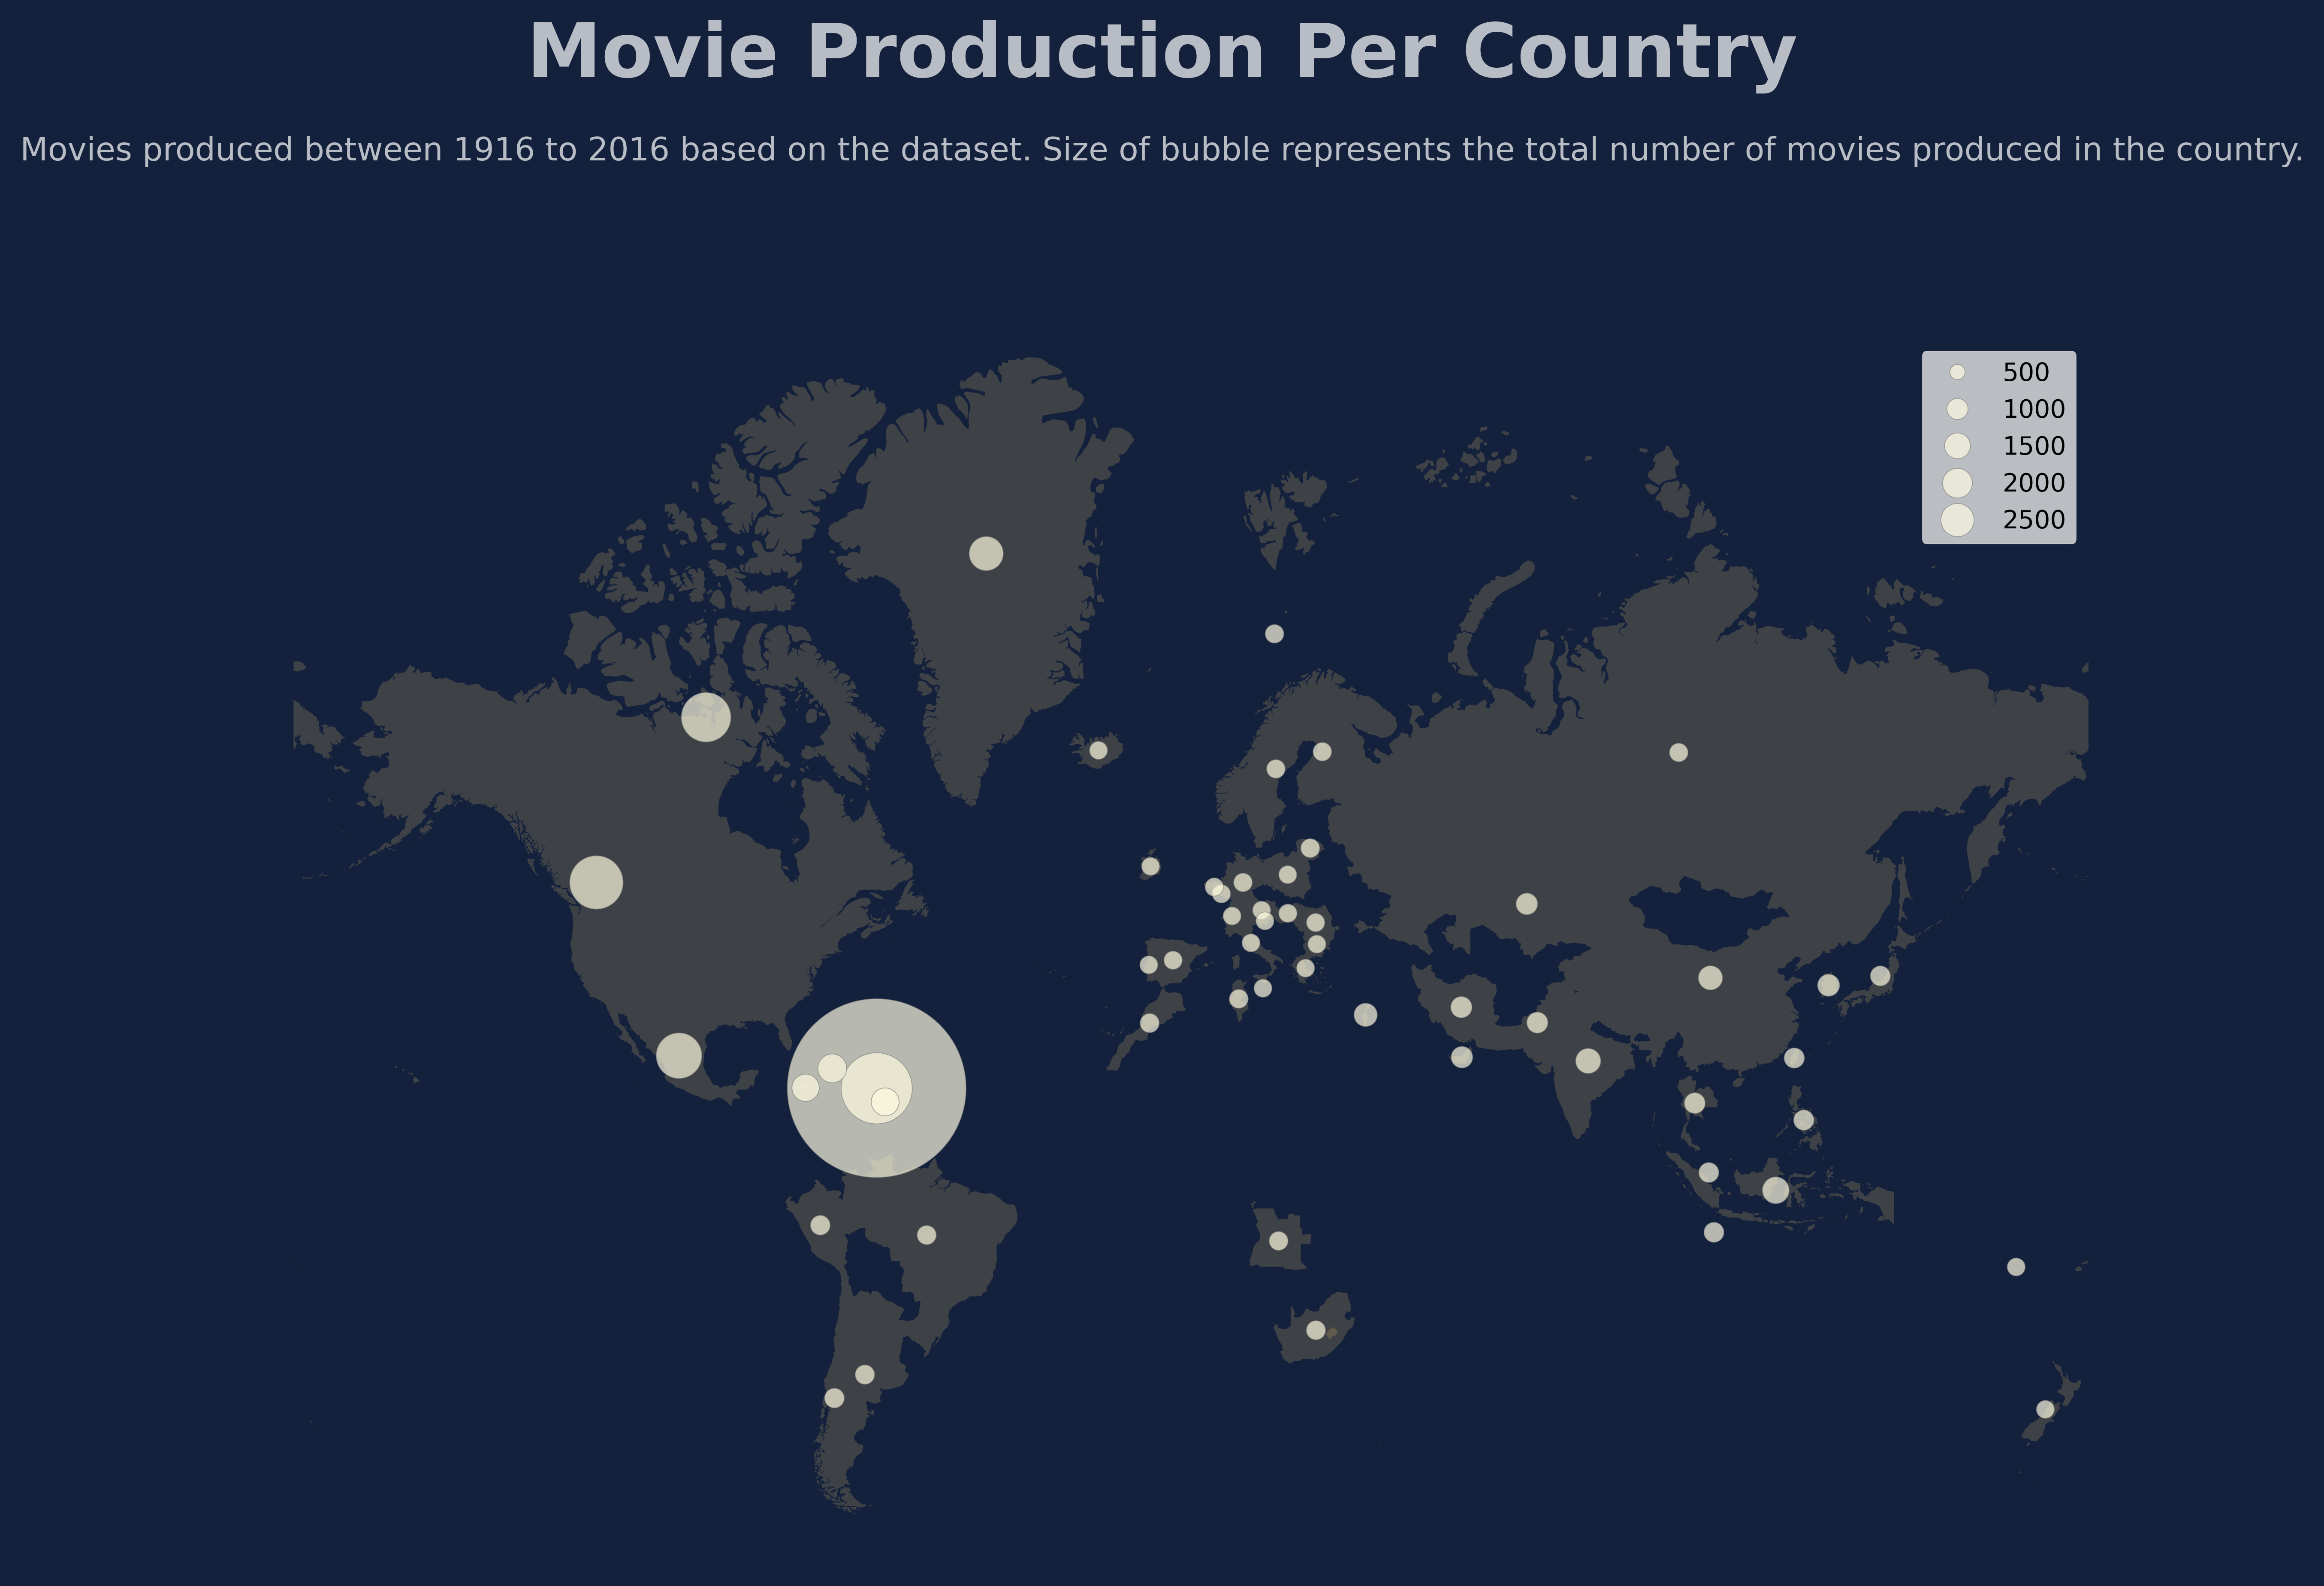

In [ ]:
# colors
background_color = '#14213d'
map_color = (233/255, 196/255, 106/255, 0.2)
bubble_color = '#fefae0'
text_color = 'white'
alpha_text = 0.7

# initialize the figure
fig, ax = plt.subplots(figsize=(18, 15), dpi=300, subplot_kw={'projection': proj})
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.set_axis_off()

# Background Map 
test2.boundary.plot(ax=ax, linewidth=0, facecolor=map_color)

# bubble on top of the map
sns.scatterplot(test2,
                x=test2['point'].x.values,
                y=test2['point'].y.values,
                size=location_count_df['count'],
                sizes=(100, 10000),
                alpha=0.7,
                ax=ax,
                legend=True,
                color=bubble_color,
                linewidth=0.4,
                edgecolor='grey',
                zorder=10,)

# title
fig_text(
   x=0.5, y=0.98, s='<Movie Production Per Country>',
   color=text_color, fontsize=42, ha='center', va='top',
   alpha=alpha_text, highlight_textprops=[{"weight": "bold"}]
)

# subtitle
fig_text(
   x=0.5, y=0.92, s="""Movies produced between 1916 to 2016 based on the dataset. Size of bubble represents the total number of movies produced in the country.""",
   color=text_color, fontsize=18, ha='center', va='top', alpha=alpha_text,
)

plt.legend(fontsize=14, markerscale=0.2)
plt.show()

`NOTE`

* The map image only has countries that are in both the datasets, showing countries that were in the the test and the locations_count_df. The Following countries were not included in the map, 'Hong Kong', 'Czech Republic', 'Bahamas', 'Serbia', 'Serbia and Montenegro'. This is because the countries did not appear in the geodata set, and therefore, didnt have the mapping geometry coordinates to be included in the map. 

* The bubble for the UK and US have been slightly offset and are not found centrally over the country

**`QUESTION`**
___
I was looking to use the above graph to show the popularity of a genre through its hue, whilst showing the relationship between returns and budget of a movie and tried to add a legend to the image with the line _`fg.add_legend(bbox_to_anchor=(1.05,1), loc='upper left')`_, but did not get the desired output, please advice on how i could get the desired outcome in future attempts 



##### **Bibliography**

1. Which movie genres uses the most cgi on average? (2024), Chatgbt GPT-4o, 28 July, Link:
<https://chatgpt.com/share/a3b073c0-da04-4e87-bdce-d5dcdc9ccad3>

2. Stephen Follows (2018), 'How long does the average Hollywood movie take to make?', _Stephen Follows Decoding The World Through Data_, 7 may, Available at:
<https://stephenfollows.com/how-long-the-average-hollywood-movie-take-to-make/>

3. Deguzman, K. (2024), 'What are the Major Film Studios — Hollywood’s Big Five', _Studiobinder_, 27 January. Available at:
<https://www.studiobinder.com/blog/what-are-the-major-film-studios/#:~:text=The%20'Big%20Five'%2C%20consisting,industry%20over%20the%20last%20century.>
(Accessed: 10 August 2024)

4. Puneyani, R. (2023), 'Top 10 Movie Studio Companies in the World', _StartupTalky_, 08 September. Available at:
<https://startuptalky.com/top-movie-studio-companies/>
(Accessed: 10 August 2024)